<p style="font-size:20px;">Simulator: QiskitAer, FakeTorino, ideal device noise simulator (no shot noise). H4(rectangular) in minimal basis (STO-3G), JW mapping, 1-layered tUPS. With zero-parameters as well as biasing parameters for training set, number of parameters is 9. Fitting methods: Square regression with a linear ansatz, add-and-subtract.</p>

In [1]:
import pyscf
import slowquant.SlowQuant as sq
from qiskit_nature.second_q.mappers import JordanWignerMapper
from slowquant.qiskit_interface.interface import QuantumInterface
from slowquant.qiskit_interface.wavefunction import WaveFunction
from slowquant.unitary_coupled_cluster.ups_wavefunction import WaveFunctionUPS
#from slowquant.qiskit_interface.linear_response.projected import quantumLR

from qiskit_ibm_runtime.fake_provider import FakeTorino

from qiskit.primitives import Estimator

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_aer.primitives import Sampler
from qiskit_aer.primitives import SamplerV2

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
from scipy.optimize import minimize
import itertools
import random
from scipy.optimize import curve_fit
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

import matplotlib.pyplot as plt

In [2]:
mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                      H 1.5 0.0 0.0;
                      H 0.0 1.8 0.0;
                      H 1.5 1.8 0.0;""", basis="sto-3g", unit="angstrom")
rhf = pyscf.scf.RHF(mol).run()

sampler = Estimator()
primitive = sampler
mapper = JordanWignerMapper()
# For H4 you can make the wavefunction better by increasing n_layers.
# n_layers: 3 will prob. give almost the FCI solution.
QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 4, "do_pp": True}, ISA = True)

WF = WaveFunction(
    mol.nao * 2,
    mol.nelectron,
    (4, 4),
    rhf.mo_coeff,
    mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
    mol.intor("int2e"),
    QI,
    include_active_kappa = True
)

#WF.run_vqe_2step("RotoSolve", maxiter=3)
#WF.run_vqe_2step("SLSQP", maxiter=40)
WF.ansatz_parameters = [3.1431228572975396, 2.7861493547159264, 3.1396692239259947, -3.142057339846848, 2.791150176990398, 3.144389766300438, -1.5653104599425836, 0.27240921676016555, 3.1384976277670154, 3.1210497755145403, 0.0655975291978254, 3.1386831001117295, 3.1672998707476467, 0.00045866400767861026, -3.113669666746792, -3.126391643474034, -0.034094707610928636, 3.151672138940099, 3.097362854855655, -0.0822620679689756, 3.0505562027648816, -3.0905175956936484, -0.011010502555054685, -3.0594652278673737, -3.149314869130154, -0.23511735777506634, 3.124078811244982, -3.400189577683653, -0.03766298071932297, -3.4773143551058996, 3.3796990528741597, 0.020211517238238847, 3.4558195393388034, 3.140869714110472, -0.08923065201729881, 3.1437217521757854]
optimized_parameters = WF.ansatz_parameters
#no noise
nonclif_ground_state_energy = WF.energy_elec
print("Non-Clifford Ground state energy:", nonclif_ground_state_energy)

#device noise
# Update the primitive with simulated noise
backend = FakeTorino()
QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
QI.do_postselection = False
QI.do_M_mitigation = False
noise_model = NoiseModel.from_backend(backend)
sampler = Sampler(backend_options={"noise_model":noise_model})
WF.change_primitive(sampler)    
# Calculate the ground state energy using the noisy simulator
noisy_nonclif_ground_state_energy = WF.energy_elec
print("Noisy Non-Clifford Ground state energy:",noisy_nonclif_ground_state_energy)

converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3


/tmp/ipykernel_816792/2393043778.py:7: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


Non-Clifford Ground state energy: -3.712421442890216
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['x', 'cz', 'reset', 'sx', 'measure', 'id']>)

Noisy Non-Clifford Ground state energy: -2.8533272018652123


In [4]:
print(WF.ansatz_parameters)

[3.1431228572975396, 2.7861493547159264, 3.1396692239259947, -3.142057339846848, 2.791150176990398, 3.144389766300438, -1.5653104599425836, 0.27240921676016555, 3.1384976277670154, 3.1210497755145403, 0.0655975291978254, 3.1386831001117295, 3.1672998707476467, 0.00045866400767861026, -3.113669666746792, -3.126391643474034, -0.034094707610928636, 3.151672138940099, 3.097362854855655, -0.0822620679689756, 3.0505562027648816, -3.0905175956936484, -0.011010502555054685, -3.0594652278673737, -3.149314869130154, -0.23511735777506634, 3.124078811244982, -3.400189577683653, -0.03766298071932297, -3.4773143551058996, 3.3796990528741597, 0.020211517238238847, 3.4558195393388034, 3.140869714110472, -0.08923065201729881, 3.1437217521757854]


In [5]:
for i in range(len(optimized_parameters)):
    if 0 < optimized_parameters[i] < np.pi/4:
        WF.ansatz_parameters[i] = 0 
    elif np.pi/4 < optimized_parameters[i] < (np.pi*3)/4:
        WF.ansatz_parameters[i] = np.pi/2
    elif (np.pi*3)/4 < optimized_parameters[i] < (np.pi*5)/4:
        WF.ansatz_parameters[i] = np.pi
    elif (np.pi*5)/4 < optimized_parameters[i] < (np.pi*7)/4:
        WF.ansatz_parameters[i] = (np.pi*3)/2
    elif (np.pi*7)/4 < optimized_parameters[i] < np.pi*2:
        WF.ansatz_parameters[i] = 0
    elif -np.pi/4 < optimized_parameters[i] < 0:
        WF.ansatz_parameters[i] = 0
    elif -(np.pi*3)/4 < optimized_parameters[i] < -np.pi/4:
        WF.ansatz_parameters[i] = -np.pi/2
    elif -(np.pi*5)/4 < optimized_parameters[i] < -(np.pi*3)/4:
        WF.ansatz_parameters[i] = -np.pi
    elif -(np.pi*7)/4 < optimized_parameters[i] < -(np.pi*5)/4:
        WF.ansatz_parameters[i] = -(np.pi*3)/2
    elif -np.pi*2 < optimized_parameters[i] < -(np.pi*7)/4:
        WF.ansatz_parameters[i] = 0
    
    for n in range(9):
        if i == 1 + 3*n:
            m = optimized_parameters[i]/4
            if 0 < m < np.pi/4:
                m = 0
                WF.ansatz_parameters[i] = 4 * m 
            elif np.pi/4 < m < (np.pi*3)/4:
                m = np.pi/2
                WF.ansatz_parameters[i] = 4 * m
            elif (np.pi*3)/4 < m < (np.pi*5)/4:
                m = np.pi
                WF.ansatz_parameters[i] = 4 * m
            elif -np.pi/4 < 0:
                m = 0
                WF.ansatz_parameters[i] = 4 * m
            elif -(np.pi*3)/4 < m < -np.pi/4:
                m = -np.pi/2
                WF.ansatz_parameters[i] = 4 * m
            elif -(np.pi*5)/4 < m < -(np.pi*3)/4:
                m = -np.pi
                WF.ansatz_parameters[i] = 4 * m

print(WF.ansatz_parameters)

[3.141592653589793, 0, 3.141592653589793, -3.141592653589793, 0, 3.141592653589793, -1.5707963267948966, 0, 3.141592653589793, 3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, -3.141592653589793, -3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, 3.141592653589793, -3.141592653589793, 0, -3.141592653589793, -3.141592653589793, 0, 3.141592653589793, -3.141592653589793, 0, -3.141592653589793, 3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, 3.141592653589793]


In [6]:
s_CGBEM_Zero = []
s_CGBEM_Bias = []
s_CDRZERO_linear = []
s_CDRZERO_nonlinear = []
s_CDRZERO_xgb = []
s_CDRZERO_mlp = []
s_CDRBIASED_linear = []
s_CDRBIASED_nonlinear = []
s_CDRBIASED_xgb = []
s_CDRBIASED_mlp = []
for _ in range(20):
    #CGBEM Zero
    mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                        H 1.5 0.0 0.0;
                        H 0.0 1.8 0.0;
                        H 1.5 1.8 0.0;""", basis="sto-3g", unit="angstrom")
    rhf = pyscf.scf.RHF(mol).run()

    primitive = Estimator()
    mapper = JordanWignerMapper()
    # For H4 you can make the wavefunction better by increasing n_layers.
    # n_layers: 3 will prob. give almost the FCI solution.
    QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 4, "do_pp": True}, ISA = True)

    WF = WaveFunction(
        mol.nao * 2,
        mol.nelectron,
        (4, 4),
        rhf.mo_coeff,
        mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
        mol.intor("int2e"),
        QI,
        include_active_kappa = True
    )

    print(WF.ansatz_parameters)

    clifford_ground_state_energy = WF.energy_elec
    print('Clifford ground state energy:', clifford_ground_state_energy)

    QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
    QI.do_postselection = False
    QI.do_M_mitigation = False
    noise_model = NoiseModel.from_backend(backend)
    sampler = Sampler(backend_options={"noise_model":noise_model})
    WF.change_primitive(sampler)
    noisy_clifford_ground_state_energy = WF.energy_elec
    print("Noisy clifford ground state energy:", noisy_clifford_ground_state_energy)
    CGBEM_Zero = noisy_nonclif_ground_state_energy + clifford_ground_state_energy - noisy_clifford_ground_state_energy
    print('AS prediction:', CGBEM_Zero)
    s_CGBEM_Zero.append(CGBEM_Zero)

    #CGBEM Bias
    mol = pyscf.M(atom="""H 0.0 0.0 0.0;
                        H 1.5 0.0 0.0;
                        H 0.0 1.8 0.0;
                        H 1.5 1.8 0.0;""", basis="sto-3g", unit="angstrom")
    rhf = pyscf.scf.RHF(mol).run()

    sampler = Estimator()
    primitive = sampler
    mapper = JordanWignerMapper()
    # For H4 you can make the wavefunction better by increasing n_layers.
    # n_layers: 3 will prob. give almost the FCI solution.
    QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 4, "do_pp": True}, ISA = True)

    WF = WaveFunction(
        mol.nao * 2,
        mol.nelectron,
        (4, 4),
        rhf.mo_coeff,
        mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
        mol.intor("int2e"),
        QI,
        #include_active_kappa = True
    )
    WF.ansatz_parameters = optimized_parameters

    for i in range(len(optimized_parameters)):
        if 0 < optimized_parameters[i] < np.pi/4:
            WF.ansatz_parameters[i] = 0 
        elif np.pi/4 < optimized_parameters[i] < (np.pi*3)/4:
            WF.ansatz_parameters[i] = np.pi/2
        elif (np.pi*3)/4 < optimized_parameters[i] < (np.pi*5)/4:
            WF.ansatz_parameters[i] = np.pi
        elif (np.pi*5)/4 < optimized_parameters[i] < (np.pi*7)/4:
            WF.ansatz_parameters[i] = (np.pi*3)/2
        elif (np.pi*7)/4 < optimized_parameters[i] < np.pi*2:
            WF.ansatz_parameters[i] = 0
        elif -np.pi/4 < optimized_parameters[i] < 0:
            WF.ansatz_parameters[i] = 0
        elif -(np.pi*3)/4 < optimized_parameters[i] < -np.pi/4:
            WF.ansatz_parameters[i] = -np.pi/2
        elif -(np.pi*5)/4 < optimized_parameters[i] < -(np.pi*3)/4:
            WF.ansatz_parameters[i] = -np.pi
        elif -(np.pi*7)/4 < optimized_parameters[i] < -(np.pi*5)/4:
            WF.ansatz_parameters[i] = -(np.pi*3)/2
        elif -np.pi*2 < optimized_parameters[i] < -(np.pi*7)/4:
            WF.ansatz_parameters[i] = 0
        
        for n in range(9):
            if i == 1 + 3*n:
                m = optimized_parameters[i]/4
                if 0 < m < np.pi/4:
                    m = 0
                    WF.ansatz_parameters[i] = 4 * m 
                elif np.pi/4 < m < (np.pi*3)/4:
                    m = np.pi/2
                    WF.ansatz_parameters[i] = 4 * m
                elif (np.pi*3)/4 < m < (np.pi*5)/4:
                    m = np.pi
                    WF.ansatz_parameters[i] = 4 * m
                elif -np.pi/4 < 0:
                    m = 0
                    WF.ansatz_parameters[i] = 4 * m
                elif -(np.pi*3)/4 < m < -np.pi/4:
                    m = -np.pi/2
                    WF.ansatz_parameters[i] = 4 * m
                elif -(np.pi*5)/4 < m < -(np.pi*3)/4:
                    m = -np.pi
                    WF.ansatz_parameters[i] = 4 * m

    print(WF.ansatz_parameters)

    clifford_ground_state_energy = WF.energy_elec
    print(clifford_ground_state_energy)

    backend = FakeTorino()
    QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
    QI.do_postselection = False
    QI.do_M_mitigation = False
    noise_model = NoiseModel.from_backend(backend)
    sampler = Sampler(backend_options={"noise_model":noise_model})
    WF.change_primitive(sampler)
    noisy_clifford_ground_state_energy = WF.energy_elec
    print(noisy_clifford_ground_state_energy)
    CGBEM_Bias = noisy_nonclif_ground_state_energy + clifford_ground_state_energy - noisy_clifford_ground_state_energy
    print('AS prediction:', CGBEM_Bias)
    s_CGBEM_Bias.append(CGBEM_Bias)

    # 给定的9个数（可以根据实际需求更改）
    numbers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
    # 生成所有可能的三个数的组合
    all_combinations = list(itertools.combinations(numbers, 3))
    # 随机选择40个不重复的组合
    selected_combinations = random.sample(all_combinations, 40)
    #CDR Zero
    #prepare training set
    zero_ground_state_energies = []
    noisy_zero_ground_state_energies = []
    n_replacements = 3

    for n in range(40):
        QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 4, "do_pp": True}, ISA = True)

        WF = WaveFunction(
        mol.nao * 2,
        mol.nelectron,
        (4, 4),
        rhf.mo_coeff,
        mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
        mol.intor("int2e"),
        QI,
        #include_active_kappa = True
        )

        indices_to_replace = selected_combinations[n]
        for index in indices_to_replace:
            WF.ansatz_parameters[index] = optimized_parameters[index]
        print(WF.ansatz_parameters)

        clif_ground_state_energy = WF.energy_elec
        zero_ground_state_energies.append(clif_ground_state_energy)
        
        backend = FakeTorino()
        QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
        QI.do_postselection = False
        QI.do_M_mitigation = False
        noise_model = NoiseModel.from_backend(backend)
        sampler = Sampler(backend_options={"noise_model":noise_model})
        WF.change_primitive(sampler)   
        noisy_clif_ground_state_energy = WF.energy_elec
        noisy_zero_ground_state_energies.append(noisy_clif_ground_state_energy)
    #data preparation
    nonclif_ground_state_energies = [nonclif_ground_state_energy for _ in range(len(zero_ground_state_energies))]
    noisy_nonclif_ground_state_energies = [noisy_nonclif_ground_state_energy for _ in range(len(noisy_zero_ground_state_energies))]
    X = np.array(noisy_zero_ground_state_energies).reshape(-1, 1)
    y = np.array(zero_ground_state_energies)
    X_test = np.array(noisy_nonclif_ground_state_energies).reshape(-1, 1)
    y_test = np.array(nonclif_ground_state_energies)
    #square regression with a linear ansatz
    def cost_function(a, X_exact, X_noisy):
        a1, a2 = a  # 将参数 a 拆分为 a1 和 a2
        # 计算代价函数 C 的值
        C = np.sum((X_exact - (a1 * X_noisy + a2))**2)
        return C
    X_exact = np.array(zero_ground_state_energies)
    X_noisy = np.array(noisy_zero_ground_state_energies)
    # 初始猜测值 a1 和 a2
    initial_guess = [1, 0]
    # 最小化代价函数
    result = minimize(cost_function, initial_guess, args=(X_exact, X_noisy))
    # 得到最优的 a1 和 a2
    a1_optimal, a2_optimal = result.x
    #print(f"最优的 a1 值: {a1_optimal}")
    #print(f"最优的 a2 值: {a2_optimal}")
    y_CDRZERO_linear = a1_optimal*noisy_nonclif_ground_state_energy + a2_optimal
    print('result of square regression:', y_CDRZERO_linear)
    s_CDRZERO_linear.append(y_CDRZERO_linear)
    #Nonlinear Fitting
    # 定义非线性拟合函数
    def nonlinear_model(X_noisy, a1, a2, a3):
        return a1 * X_noisy**2 + a2 * X_noisy + a3

    # 输入数据
    X_exact = np.array(zero_ground_state_energies)
    X_noisy = np.array(noisy_zero_ground_state_energies)

    # 使用 curve_fit 进行非线性拟合
    # 初始猜测值 [a1, a2, a3]
    initial_guess = [1, 1, 0]
    params, covariance = curve_fit(nonlinear_model, X_noisy, X_exact, p0=initial_guess)

    # 提取拟合参数
    a1_optimal, a2_optimal, a3_optimal = params
    #print(f"最优的 a1 值: {a1_optimal}")
    #print(f"最优的 a2 值: {a2_optimal}")
    #print(f"最优的 a3 值: {a3_optimal}")

    # 对新的数据进行预测
    y_CDRZERO_nonlinear = nonlinear_model(noisy_nonclif_ground_state_energy, a1_optimal, a2_optimal, a3_optimal)
    print('Result of Nonlinear Fitting:', y_CDRZERO_nonlinear)
    s_CDRZERO_nonlinear.append(y_CDRZERO_nonlinear)
    #XGBoost
    xgb_model = XGBRegressor(max_depth=20, eta=0.0005, subsample=0.7, colsample_bytree=0.7, objective='reg:absoluteerror', n_estimators=1000, random_state=42)
    xgb_model.fit(X, y)
    y_CDRZERO_xgb = xgb_model.predict(X_test)
    # 计算均方误差
    #mse_corrected_XGB = mean_squared_error(y_test, y_pred_xgb)
    #print('mse:', mse_corrected_XGB)
    print('result of xgb:', y_CDRZERO_xgb[0])
    s_CDRZERO_xgb.append(y_CDRZERO_xgb[0])
    #MLP
    # 归一化数据
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # 训练MLP模型
    mlp_model = MLPRegressor(hidden_layer_sizes=(120, 60), activation='relu', solver='adam', max_iter=2000, alpha=0.001, random_state=42)
    mlp_model.fit(X_scaled, y)
    X_test_scaled = scaler.transform(X_test)
    y_CDRZERO_mlp = mlp_model.predict(X_test_scaled)
    #mse_corrected_MLP = mean_squared_error(y_test, y_pred_mlp)
    #print('mse:', mse_corrected_MLP)
    print('result of mlp:', y_CDRZERO_mlp[0])
    s_CDRZERO_mlp.append(y_CDRZERO_mlp[0])

    #CDR Bias
    #prepare training set
    bias_ground_state_energies = []
    noisy_bias_ground_state_energies = []
    n_replacements = 3

    for n in range(40):
        QI = QuantumInterface(primitive, "tUPS", mapper, ansatz_options={"n_layers": 4, "do_pp": True}, ISA = True)

        WF = WaveFunction(
        mol.nao * 2,
        mol.nelectron,
        (4, 4),
        rhf.mo_coeff,
        mol.intor("int1e_kin") + mol.intor("int1e_nuc"),
        mol.intor("int2e"),
        QI,
        #include_active_kappa = True
        )
        WF.ansatz_parameters = [3.141592653589793, 0, 3.141592653589793, -3.141592653589793, 0, 3.141592653589793, -1.5707963267948966, 0, 3.141592653589793, 3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, -3.141592653589793, -3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, 3.141592653589793, -3.141592653589793, 0, -3.141592653589793, -3.141592653589793, 0, 3.141592653589793, -3.141592653589793, 0, -3.141592653589793, 3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, 3.141592653589793]
        
        indices_to_replace = selected_combinations[n]
        for index in indices_to_replace:
            WF.ansatz_parameters[index] = optimized_parameters[index]
        print(WF.ansatz_parameters)

        clif_ground_state_energy = WF.energy_elec
        bias_ground_state_energies.append(clif_ground_state_energy)
        
        backend = FakeTorino()
        QI.pass_manager = generate_preset_pass_manager(3,backend=backend,seed_transpiler=123) # seeded standard transpiler
        QI.do_postselection = False
        QI.do_M_mitigation = False
        noise_model = NoiseModel.from_backend(backend)
        sampler = Sampler(backend_options={"noise_model":noise_model})
        WF.change_primitive(sampler)   
        noisy_clif_ground_state_energy = WF.energy_elec
        noisy_bias_ground_state_energies.append(noisy_clif_ground_state_energy)
    #data preparation
    nonclif_ground_state_energies = [nonclif_ground_state_energy for _ in range(len(bias_ground_state_energies))]
    noisy_nonclif_ground_state_energies = [noisy_nonclif_ground_state_energy for _ in range(len(noisy_bias_ground_state_energies))]
    X = np.array(noisy_bias_ground_state_energies).reshape(-1, 1)
    y = np.array(bias_ground_state_energies)
    X_test = np.array(noisy_nonclif_ground_state_energies).reshape(-1, 1)
    y_test = np.array(nonclif_ground_state_energies)
    #square regression with a linear ansatz
    def cost_function(a, X_exact, X_noisy):
        a1, a2 = a  # 将参数 a 拆分为 a1 和 a2
        # 计算代价函数 C 的值
        C = np.sum((X_exact - (a1 * X_noisy + a2))**2)
        return C
    X_exact = np.array(bias_ground_state_energies)
    X_noisy = np.array(noisy_bias_ground_state_energies)
    # 初始猜测值 a1 和 a2
    initial_guess = [1, 0]
    # 最小化代价函数
    result = minimize(cost_function, initial_guess, args=(X_exact, X_noisy))
    # 得到最优的 a1 和 a2
    a1_optimal, a2_optimal = result.x
    #print(f"最优的 a1 值: {a1_optimal}")
    #print(f"最优的 a2 值: {a2_optimal}")
    y_CDRBIASED_linear = a1_optimal*noisy_nonclif_ground_state_energy + a2_optimal
    print('result of square regression:', y_CDRBIASED_linear)
    s_CDRBIASED_linear.append(y_CDRBIASED_linear)
    #Nonlinear Fitting
    # 定义非线性拟合函数
    def nonlinear_model(X_noisy, a1, a2, a3):
        return a1 * X_noisy**2 + a2 * X_noisy + a3

    # 输入数据
    X_exact = np.array(bias_ground_state_energies)
    X_noisy = np.array(noisy_bias_ground_state_energies)

    # 使用 curve_fit 进行非线性拟合
    # 初始猜测值 [a1, a2, a3]
    initial_guess = [1, 1, 0]
    params, covariance = curve_fit(nonlinear_model, X_noisy, X_exact, p0=initial_guess)

    # 提取拟合参数
    a1_optimal, a2_optimal, a3_optimal = params
    #print(f"最优的 a1 值: {a1_optimal}")
    #print(f"最优的 a2 值: {a2_optimal}")
    #print(f"最优的 a3 值: {a3_optimal}")

    # 对新的数据进行预测
    y_CDRBIASED_nonlinear = nonlinear_model(noisy_nonclif_ground_state_energy, a1_optimal, a2_optimal, a3_optimal)
    print('Result of Nonlinear Fitting:', y_CDRBIASED_nonlinear)
    s_CDRBIASED_nonlinear.append(y_CDRBIASED_nonlinear)
    #XGBoost
    xgb_model = XGBRegressor(max_depth=20, eta=0.0005, subsample=0.7, colsample_bytree=0.7, objective='reg:absoluteerror', n_estimators=1000, random_state=42)
    xgb_model.fit(X, y)
    y_CDRBIASED_xgb = xgb_model.predict(X_test)
    # 计算均方误差
    #mse_corrected_XGB = mean_squared_error(y_test, y_pred_xgb)
    #print('mse:', mse_corrected_XGB)
    print('result of xgb:', y_CDRBIASED_xgb[0])
    s_CDRBIASED_xgb.append(y_CDRBIASED_xgb[0])
    #MLP
    # 归一化数据
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    # 训练MLP模型
    mlp_model = MLPRegressor(hidden_layer_sizes=(120, 60), activation='relu', solver='adam', max_iter=2000, alpha=0.001, random_state=42)
    mlp_model.fit(X_scaled, y)
    X_test_scaled = scaler.transform(X_test)
    y_CDRBIASED_mlp = mlp_model.predict(X_test_scaled)
    #mse_corrected_MLP = mean_squared_error(y_test, y_pred_mlp)
    #print('mse:', mse_corrected_MLP)
    print('result of mlp:', y_CDRBIASED_mlp[0])
    s_CDRBIASED_mlp.append(y_CDRBIASED_mlp[0])

converged SCF energy = -1.77674731624872


Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Clifford ground state energy: -3.2895813578825934
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

Noisy clifford ground state energy: -2.9251505188108116
AS prediction: -3.217758040936996
converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


[3.141592653589793, 0, 3.141592653589793, -3.141592653589793, 0, 3.141592653589793, -1.5707963267948966, 0, 3.141592653589793, 3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, -3.141592653589793, -3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, 3.141592653589793, -3.141592653589793, 0, -3.141592653589793, -3.141592653589793, 0, 3.141592653589793, -3.141592653589793, 0, -3.141592653589793, 3.141592653589793, 0, 3.141592653589793, 3.141592653589793, 0, 3.141592653589793]
-3.5219862697272935
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 P

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Clifford ground state energy: -3.289581357882591
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

Noisy clifford ground state energy: -2.9251505188108133
AS prediction: -3.2177580409369924
converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.5219862697272935
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128297242858157
AS prediction: -3.462483747306692
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None wi

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.289581357882591
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Tra

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.5219862697272935
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128297242858157
AS prediction: -3.462483747306692
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None wi

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Clifford ground state energy: -3.289581357882593
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

Noisy clifford ground state energy: -2.9251505188108116
AS prediction: -3.217758040936996
converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed.

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.5219862697272943
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128296686701383
AS prediction: -3.46248380292237
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None wit

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.2895813578825943
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

N

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.5219862697272966
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.912829668670139
AS prediction: -3.462483802922372
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None wit

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Clifford ground state energy: -3.2895813578825925
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

Noisy clifford ground state energy: -2.9251505188108085
AS prediction: -3.217758040936998
converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.521986269727294
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128296686701365
AS prediction: -3.462483802922371
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None wit

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Clifford ground state energy: -3.28958135788259
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

Noisy clifford ground state energy: -2.925150518810807
AS prediction: -3.217758040936997
converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed.
Y

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.521986269727292
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128297242858148
AS prediction: -3.462483747306691
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None wit

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.2895813578825917
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Tr

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.5219862697272935
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128297242858157
AS prediction: -3.462483747306692
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None wi

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.289581357882593
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Tra

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.5219862697272917
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128296686701365
AS prediction: -3.4624838029223692
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None w

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()



You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.2895813578825925
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitiv

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.521986269727294
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128296686701374
AS prediction: -3.46248380292237
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()



You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.289581357882592
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.521986269727296
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.912829724285816
AS prediction: -3.462483747306694
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()



You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.289581357882593
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.5219862697272943
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128296686701383
AS prediction: -3.46248380292237
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None wit

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()



You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.2895813578825908
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitiv

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.5219862697272935
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128297242858157
AS prediction: -3.462483747306692
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None wi

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Clifford ground state energy: -3.2895813578825917
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

Noisy clifford ground state energy: -2.925150517428731
AS prediction: -3.217758042319075
converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed.

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.521986269727294
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.912829668670139
AS prediction: -3.4624838029223683
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None wit

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()



You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.2895813578825894
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitiv

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.521986269727293
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.912829724285814
AS prediction: -3.4624837473066936
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None wit

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()



You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.2895813578825934
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitiv

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.5219862697272957
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128296686701396
AS prediction: -3.4624838029223697
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None w

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()



You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.289581357882588
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.5219862697272957
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128296686701396
AS prediction: -3.4624838029223697
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None w

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.2895813578825894
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Tr

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.5219862697272935
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128296686701383
AS prediction: -3.4624838029223692
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None w

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()



You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None with optimization level 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Clifford ground state energy: -3.289581357882588
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive

/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.521986269727295
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.9128296686701387
AS prediction: -3.4624838029223706
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None wi

/tmp/ipykernel_3908309/840724556.py:19: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  primitive = Estimator()


Clifford ground state energy: -3.289581357882593
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

Noisy clifford ground state energy: -2.92515051881081
AS prediction: -3.2177580409369977
converged SCF energy = -1.77674731624872
Number of shots is None. Ideal simulator is assumed.


/tmp/ipykernel_3908309/840724556.py:60: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  sampler = Estimator()


-3.521986269727295
Using this function is only recommended for switching from ideal simulator to shot-noise or quantum hardware.
                 Multiple switching back and forth can lead to un-expected outcomes and is an experimental feature.

Reset RDMs, energies, and QI metrics.
Number of shots is None. Ideal simulator is assumed.
Your settings are:
 Ansatz:              tUPS
 Number of shots:     None
 ISA                  True
 Transpiled circuit   True
 Primitive:           Sampler
 Post-processing:     False
 Circuit layout:      [44, 26, 27, 17, 43, 25, 35, 28]
 Non-local gates:     528
 Transpilation strategy: External PassManager
 Primitive backend:   AerSimulator('aer_simulator'
             noise_model=<NoiseModel on ['reset', 'measure', 'sx', 'x', 'cz', 'id']>)

-2.912829668670138
AS prediction: -3.4624838029223715
Number of shots is None. Ideal simulator is assumed.
You selected ISA but did not pass a PassManager. Standard internal transpilation will use backend None wit

In [7]:
print(s_CGBEM_Zero)
print(s_CGBEM_Bias)
print(s_CDRZERO_linear)
print(s_CDRZERO_nonlinear)
print(s_CDRZERO_xgb)
print(s_CDRZERO_mlp)
print(s_CDRBIASED_linear)
print(s_CDRBIASED_nonlinear)
print(s_CDRBIASED_xgb)
print(s_CDRBIASED_mlp)

[np.float64(-3.217758040936996), np.float64(-3.2177580409369924), np.float64(-3.2177580423190744), np.float64(-3.217758040936996), np.float64(-3.2177580423190735), np.float64(-3.217758040936998), np.float64(-3.217758040936997), np.float64(-3.2177580409369972), np.float64(-3.2177580409369977), np.float64(-3.217758040936998), np.float64(-3.217758042319071), np.float64(-3.217758040936996), np.float64(-3.2177580409369964), np.float64(-3.217758042319075), np.float64(-3.217758042319071), np.float64(-3.2177580423190735), np.float64(-3.217758040936995), np.float64(-3.2177580423190717), np.float64(-3.217758040936994), np.float64(-3.2177580409369977)]
[np.float64(-3.462483747306692), np.float64(-3.462483747306692), np.float64(-3.462483747306692), np.float64(-3.46248380292237), np.float64(-3.462483802922372), np.float64(-3.462483802922371), np.float64(-3.462483747306691), np.float64(-3.462483747306692), np.float64(-3.4624838029223692), np.float64(-3.46248380292237), np.float64(-3.462483747306694)

In [8]:
import csv
# 列表名称和数据
data = [
    ("CGBEM_Zero", s_CGBEM_Zero),
    ("CGBEM_Bias", s_CGBEM_Bias),
    ("CDRZERO_linear", s_CDRZERO_linear),
    ("CDRZERO_nonlinear", s_CDRZERO_nonlinear),
    ("CDRZERO_xgb", s_CDRZERO_xgb),
    ("CDRZERO_mlp", s_CDRZERO_mlp),
    ("CDRBIASED_linear", s_CDRBIASED_linear),
    ("CDRBIASED_nonlinear", s_CDRBIASED_nonlinear),
    ("CDRBIASED_xgb", s_CDRBIASED_xgb),
    ("CDRBIASED_mlp", s_CDRBIASED_mlp),
]

# 计算最长列表的长度
max_length = max(len(lst) for _, lst in data)

# 填充短列表，使它们的长度一致
for name, lst in data:
    lst.extend([None] * (max_length - len(lst)))

# 保存为 CSV 文件
with open('CBGEM&CDR_statistics_4layers.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # 写入表头
    writer.writerow([name for name, _ in data])
    
    # 写入每一行数据
    for i in range(max_length):
        writer.writerow([lst[i] for _, lst in data])

print("文件已保存为 CBGEM&CDR_statistics_4layers.csv")

文件已保存为 CBGEM&CDR_statistics_4layers.csv


In [ ]:
import csv

# 初始化空列表
s_CGBEM_Zero = []
s_CGBEM_Bias = []
s_CDRZERO_linear = []
s_CDRZERO_nonlinear = []
s_CDRZERO_xgb = []
s_CDRZERO_mlp = []
s_CDRBIASED_linear = []
s_CDRBIASED_nonlinear = []
s_CDRBIASED_xgb = []
s_CDRBIASED_mlp = []

# 定义列表名称和对应变量
data_map = {
    "CGBEM_Zero": s_CGBEM_Zero,
    "CGBEM_Bias": s_CGBEM_Bias,
    "CDRZERO_linear": s_CDRZERO_linear,
    "CDRZERO_nonlinear": s_CDRZERO_nonlinear,
    "CDRZERO_xgb": s_CDRZERO_xgb,
    "CDRZERO_mlp": s_CDRZERO_mlp,
    "CDRBIASED_linear": s_CDRBIASED_linear,
    "CDRBIASED_nonlinear": s_CDRBIASED_nonlinear,
    "CDRBIASED_xgb": s_CDRBIASED_xgb,
    "CDRBIASED_mlp": s_CDRBIASED_mlp,
}

# 从 CSV 文件读取数据
with open('CBGEM&CDR_statistics_4layers.csv', mode='r') as file:
    reader = csv.reader(file)
    
    # 读取表头（列表名称）
    headers = next(reader)
    
    # 按列读取数据
    columns = {header: [] for header in headers}
    for row in reader:
        for header, value in zip(headers, row):
            columns[header].append(value if value != '' else None)

# 将数据加载到对应的列表中
for name, lst in columns.items():
    data_map[name].extend(lst)

# 打印每个列表以验证
print("s_CGBEM_Zero:", s_CGBEM_Zero)
print("s_CGBEM_Bias:", s_CGBEM_Bias)
print("s_CDRZERO_linear:", s_CDRZERO_linear)
print("s_CDRZERO_nonlinear:", s_CDRZERO_nonlinear)
print("s_CDRZERO_xgb:", s_CDRZERO_xgb)
print("s_CDRZERO_mlp:", s_CDRZERO_mlp)
print("s_CDRBIASED_linear:", s_CDRBIASED_linear)
print("s_CDRBIASED_nonlinear:", s_CDRBIASED_nonlinear)
print("s_CDRBIASED_xgb:", s_CDRBIASED_xgb)
print("s_CDRBIASED_mlp:", s_CDRBIASED_mlp)

s_CGBEM_Zero: ['-3.217758040936996', '-3.2177580409369924', '-3.2177580423190744', '-3.217758040936996', '-3.2177580423190735', '-3.217758040936998', '-3.217758040936997', '-3.2177580409369972', '-3.2177580409369977', '-3.217758040936998', '-3.217758042319071', '-3.217758040936996', '-3.2177580409369964', '-3.217758042319075', '-3.217758042319071', '-3.2177580423190735', '-3.217758040936995', '-3.2177580423190717', '-3.217758040936994', '-3.2177580409369977']
s_CGBEM_Bias: ['-3.462483747306692', '-3.462483747306692', '-3.462483747306692', '-3.46248380292237', '-3.462483802922372', '-3.462483802922371', '-3.462483747306691', '-3.462483747306692', '-3.4624838029223692', '-3.46248380292237', '-3.462483747306694', '-3.46248380292237', '-3.462483747306692', '-3.4624838029223683', '-3.4624837473066936', '-3.4624838029223697', '-3.4624838029223697', '-3.4624838029223692', '-3.4624838029223706', '-3.4624838029223715']
s_CDRZERO_linear: ['-4.645517465321198', '-4.646545724500683', '-4.645155613

In [4]:
# 将字符串转换为浮点数
s_CGBEM_Zero = [float(x) for x in s_CGBEM_Zero]
s_CGBEM_Bias = [float(x) for x in s_CGBEM_Bias]
s_CDRZERO_linear = [float(x) for x in s_CDRZERO_linear]
s_CDRZERO_nonlinear = [float(x) for x in s_CDRZERO_nonlinear]
s_CDRZERO_xgb = [float(x) for x in s_CDRZERO_xgb]
s_CDRZERO_mlp = [float(x) for x in s_CDRZERO_mlp]
s_CDRBIASED_linear = [float(x) for x in s_CDRBIASED_linear]
s_CDRBIASED_nonlinear = [float(x) for x in s_CDRBIASED_nonlinear]
s_CDRBIASED_xgb = [float(x) for x in s_CDRBIASED_xgb]
s_CDRBIASED_mlp = [float(x) for x in s_CDRBIASED_mlp]
# 计算平均值并存储为独立变量
avg_CGBEM_Zero = sum(s_CGBEM_Zero) / len(s_CGBEM_Zero)
avg_CGBEM_Bias = sum(s_CGBEM_Bias) / len(s_CGBEM_Bias)
avg_CDRZERO_linear = sum(s_CDRZERO_linear) / len(s_CDRZERO_linear)
avg_CDRZERO_nonlinear = sum(s_CDRZERO_nonlinear) / len(s_CDRZERO_nonlinear)
avg_CDRZERO_xgb = sum(s_CDRZERO_xgb) / len(s_CDRZERO_xgb)
avg_CDRZERO_mlp = sum(s_CDRZERO_mlp) / len(s_CDRZERO_mlp)
avg_CDRBIASED_linear = sum(s_CDRBIASED_linear) / len(s_CDRBIASED_linear)
avg_CDRBIASED_nonlinear = sum(s_CDRBIASED_nonlinear) / len(s_CDRBIASED_nonlinear)
avg_CDRBIASED_xgb = sum(s_CDRBIASED_xgb) / len(s_CDRBIASED_xgb)
avg_CDRBIASED_mlp = sum(s_CDRBIASED_mlp) / len(s_CDRBIASED_mlp)

# 打印结果
print("avg_CGBEM_Zero:", avg_CGBEM_Zero)
print("avg_CGBEM_Bias:", avg_CGBEM_Bias)
print("avg_CDRZERO_linear:", avg_CDRZERO_linear)
print("avg_CDRZERO_nonlinear:", avg_CDRZERO_nonlinear)
print("avg_CDRZERO_xgb:", avg_CDRZERO_xgb)
print("avg_CDRZERO_mlp:", avg_CDRZERO_mlp)
print("avg_CDRBIASED_linear:", avg_CDRBIASED_linear)
print("avg_CDRBIASED_nonlinear:", avg_CDRBIASED_nonlinear)
print("avg_CDRBIASED_xgb:", avg_CDRBIASED_xgb)
print("avg_CDRBIASED_mlp:", avg_CDRBIASED_mlp)

avg_CGBEM_Zero: -3.2177580414207227
avg_CGBEM_Bias: -3.4624837806760986
avg_CDRZERO_linear: -4.645436060586173
avg_CDRZERO_nonlinear: -10.288063874549021
avg_CDRZERO_xgb: -3.3753939950000005
avg_CDRZERO_mlp: -17.45483554818667
avg_CDRBIASED_linear: -3.451352080684683
avg_CDRBIASED_nonlinear: -1.7093159920109726
avg_CDRBIASED_xgb: -3.5219864999999997
avg_CDRBIASED_mlp: -3.6220079601282174


In [5]:
import math

# 定义计算标准差的函数
def calculate_stddev(lst):
    if len(lst) == 0:
        return None
    mean = sum(lst) / len(lst)
    variance = sum((x - mean) ** 2 for x in lst) / len(lst)
    return math.sqrt(variance)

# 计算标准差
std_CGBEM_Zero = calculate_stddev(s_CGBEM_Zero)
std_CGBEM_Bias = calculate_stddev(s_CGBEM_Bias)
std_CDRZERO_linear = calculate_stddev(s_CDRZERO_linear)
std_CDRZERO_nonlinear = calculate_stddev(s_CDRZERO_nonlinear)
std_CDRZERO_xgb = calculate_stddev(s_CDRZERO_xgb)
std_CDRZERO_mlp = calculate_stddev(s_CDRZERO_mlp)
std_CDRBIASED_linear = calculate_stddev(s_CDRBIASED_linear)
std_CDRBIASED_nonlinear = calculate_stddev(s_CDRBIASED_nonlinear)
std_CDRBIASED_xgb = calculate_stddev(s_CDRBIASED_xgb)
std_CDRBIASED_mlp = calculate_stddev(s_CDRBIASED_mlp)

# 打印结果
print("std_CGBEM_Zero:", std_CGBEM_Zero)
print("std_CGBEM_Bias:", std_CGBEM_Bias)
print("std_CDRZERO_linear:", std_CDRZERO_linear)
print("std_CDRZERO_nonlinear:", std_CDRZERO_nonlinear)
print("std_CDRZERO_xgb:", std_CDRZERO_xgb)
print("std_CDRZERO_mlp:", std_CDRZERO_mlp)
print("std_CDRBIASED_linear:", std_CDRBIASED_linear)
print("std_CDRBIASED_nonlinear:", std_CDRBIASED_nonlinear)
print("std_CDRBIASED_xgb:", std_CDRBIASED_xgb)
print("std_CDRBIASED_mlp:", std_CDRBIASED_mlp)

# 打印结果，使用科学记数法
print("std_CGBEM_Zero: {:.2e}".format(std_CGBEM_Zero))
print("std_CGBEM_Bias: {:.2e}".format(std_CGBEM_Bias))
print("std_CDRZERO_linear: {:.2e}".format(std_CDRZERO_linear))
print("std_CDRZERO_nonlinear: {:.2e}".format(std_CDRZERO_nonlinear))
print("std_CDRZERO_xgb: {:.2e}".format(std_CDRZERO_xgb))
print("std_CDRZERO_mlp: {:.2e}".format(std_CDRZERO_mlp))
print("std_CDRBIASED_linear: {:.2e}".format(std_CDRBIASED_linear))
print("std_CDRBIASED_nonlinear: {:.2e}".format(std_CDRBIASED_nonlinear))
print("std_CDRBIASED_xgb: {:.2e}".format(std_CDRBIASED_xgb))
print("std_CDRBIASED_mlp: {:.2e}".format(std_CDRBIASED_mlp))

std_CGBEM_Zero: 6.592084878237194e-10
std_CGBEM_Bias: 2.7246006509012925e-08
std_CDRZERO_linear: 0.0007225830533035871
std_CDRZERO_nonlinear: 1.4108970189971428
std_CDRZERO_xgb: 0.00828763498873322
std_CDRZERO_mlp: 0.5442798605535781
std_CDRBIASED_linear: 3.18540976796879e-08
std_CDRBIASED_nonlinear: 2.7361480389188393
std_CDRBIASED_xgb: 4.440892098500626e-16
std_CDRBIASED_mlp: 4.150634451462449e-09
std_CGBEM_Zero: 6.59e-10
std_CGBEM_Bias: 2.72e-08
std_CDRZERO_linear: 7.23e-04
std_CDRZERO_nonlinear: 1.41e+00
std_CDRZERO_xgb: 8.29e-03
std_CDRZERO_mlp: 5.44e-01
std_CDRBIASED_linear: 3.19e-08
std_CDRBIASED_nonlinear: 2.74e+00
std_CDRBIASED_xgb: 4.44e-16
std_CDRBIASED_mlp: 4.15e-09


In [6]:
delta_CBGEM_zero = nonclif_ground_state_energy - avg_CGBEM_Zero
delta_CBGEM_bias = nonclif_ground_state_energy - avg_CGBEM_Bias
delta_CDRlinear_zero = nonclif_ground_state_energy - avg_CDRZERO_linear
delta_CDRnonlinear_zero = nonclif_ground_state_energy - avg_CDRZERO_nonlinear
delta_CDRxgb_zero = nonclif_ground_state_energy - avg_CDRZERO_xgb
delta_CDRmlp_zero = nonclif_ground_state_energy - avg_CDRZERO_mlp
delta_CDRlinear_bias = nonclif_ground_state_energy - avg_CDRBIASED_linear
delta_CDRnonlinear_bias = nonclif_ground_state_energy - avg_CDRBIASED_nonlinear
delta_CDRxgb_bias = nonclif_ground_state_energy - avg_CDRBIASED_xgb
delta_CDRmlp_bias = nonclif_ground_state_energy - avg_CDRBIASED_mlp
print('CBGEM_zero', delta_CBGEM_zero)
print('CBGEM_bias', delta_CBGEM_bias)
print('CDRlinear_zero', delta_CDRlinear_zero)
print('CDRnonlinear_zero', delta_CDRnonlinear_zero)
print('CDRxgb_zero', delta_CDRxgb_zero)
print('CDRmlp_zero', delta_CDRmlp_zero)
print('CDRlinear_bias', delta_CDRlinear_bias)
print('CDRnonlinear_bias', delta_CDRnonlinear_bias)
print('CDRxgb_bias', delta_CDRxgb_bias)
print('CDRmlp_bias', delta_CDRmlp_bias)

print('CBGEM_zero: {:.2e}'.format(delta_CBGEM_zero))
print('CBGEM_bias: {:.2e}'.format(delta_CBGEM_bias))
print('CDRlinear_zero: {:.2e}'.format(delta_CDRlinear_zero))
print('CDRnonlinear_zero: {:.2e}'.format(delta_CDRnonlinear_zero))
print('CDRxgb_zero: {:.2e}'.format(delta_CDRxgb_zero))
print('CDRmlp_zero: {:.2e}'.format(delta_CDRmlp_zero))
print('CDRlinear_bias: {:.2e}'.format(delta_CDRlinear_bias))
print('CDRnonlinear_bias: {:.2e}'.format(delta_CDRnonlinear_bias))
print('CDRxgb_bias: {:.2e}'.format(delta_CDRxgb_bias))
print('CDRmlp_bias: {:.2e}'.format(delta_CDRmlp_bias))

CBGEM_zero -0.4946634014694933
CBGEM_bias -0.2499376622141174
CDRlinear_zero 0.9330146176959566
CDRnonlinear_zero 6.575642431658805
CDRxgb_zero -0.33702744789021555
CDRmlp_zero 13.742414105296453
CDRlinear_bias -0.2610693622055331
CDRnonlinear_bias -2.0031054508792434
CDRxgb_bias -0.19043494289021634
CDRmlp_bias -0.09041348276199868
CBGEM_zero: -4.95e-01
CBGEM_bias: -2.50e-01
CDRlinear_zero: 9.33e-01
CDRnonlinear_zero: 6.58e+00
CDRxgb_zero: -3.37e-01
CDRmlp_zero: 1.37e+01
CDRlinear_bias: -2.61e-01
CDRnonlinear_bias: -2.00e+00
CDRxgb_bias: -1.90e-01
CDRmlp_bias: -9.04e-02


/tmp/ipykernel_3981163/256556387.py:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()  # 自动调整布局


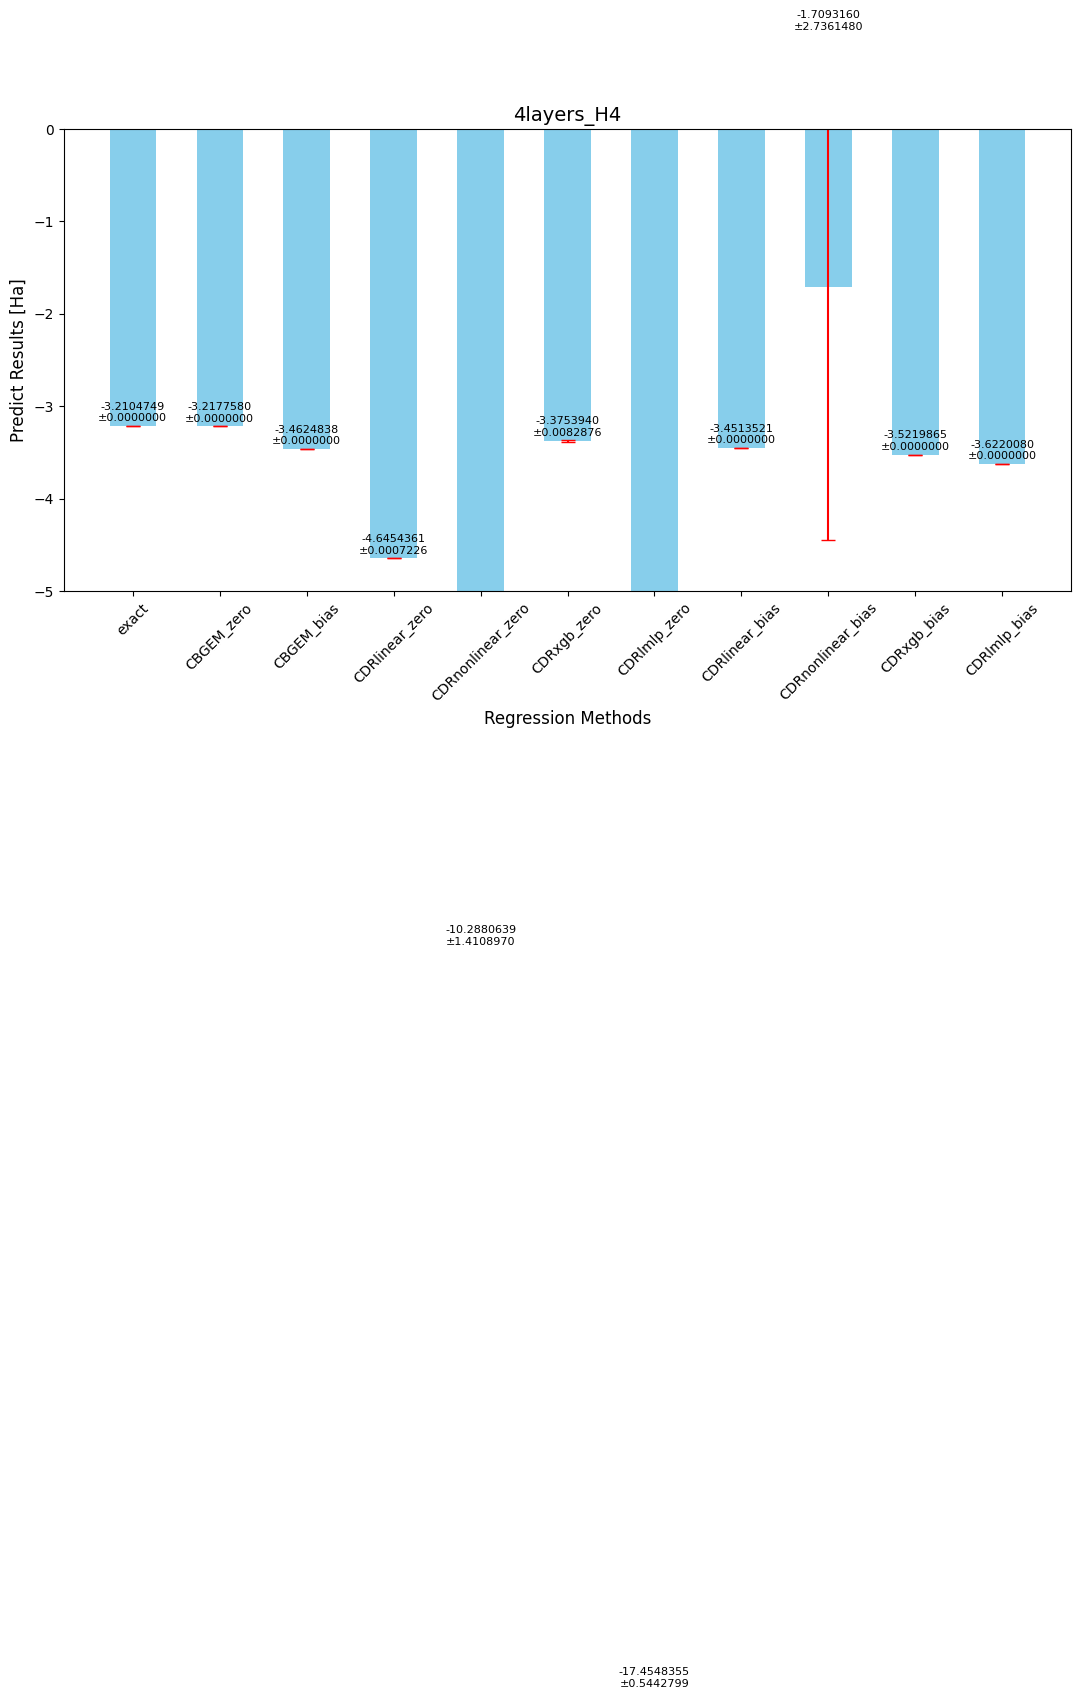

In [10]:
# 数据
categories = ['exact', 'CBGEM_zero', 'CBGEM_bias', 'CDRlinear_zero', 'CDRnonlinear_zero', 
              'CDRxgb_zero', 'CDRlmlp_zero', 'CDRlinear_bias', 'CDRnonlinear_bias', 'CDRxgb_bias', 'CDRlmlp_bias']
values = [nonclif_ground_state_energy, avg_CGBEM_Zero, avg_CGBEM_Bias, avg_CDRZERO_linear, 
          avg_CDRZERO_nonlinear, avg_CDRZERO_xgb, avg_CDRZERO_mlp, avg_CDRBIASED_linear, 
          avg_CDRBIASED_nonlinear, avg_CDRBIASED_xgb, avg_CDRBIASED_mlp]
std_devs = [0, std_CGBEM_Zero, std_CGBEM_Bias, std_CDRZERO_linear, 
            std_CDRZERO_nonlinear, std_CDRZERO_xgb, std_CDRZERO_mlp, 
            std_CDRBIASED_linear, std_CDRBIASED_nonlinear, std_CDRBIASED_xgb, std_CDRBIASED_mlp]  # 标准差数据

# 图形设置
plt.figure(figsize=(13, 6))
x_positions = np.arange(len(categories)) * 1.5  # 调整 x 轴间距

# 绘制柱状图，添加误差条
plt.bar(x_positions, values, yerr=std_devs, capsize=5, color='skyblue', ecolor='red')

# 添加标题和标签
plt.title('4layers_H4', fontsize=14)
plt.xlabel('Regression Methods', fontsize=12)
plt.ylabel('Predict Results [Ha]', fontsize=12)
plt.ylim(-5, 0)
# 设置 x 轴刻度和标签
plt.xticks(x_positions, categories, fontsize=10, rotation=45)

# 在柱子顶部标注值和标准差
for i, (v, std) in enumerate(zip(values, std_devs)):
    plt.text(x_positions[i], v + std + 0.05, f"{v:.7f}\n±{std:.7f}", ha='center', fontsize=8)

# 显示图表
plt.tight_layout()  # 自动调整布局
plt.show()

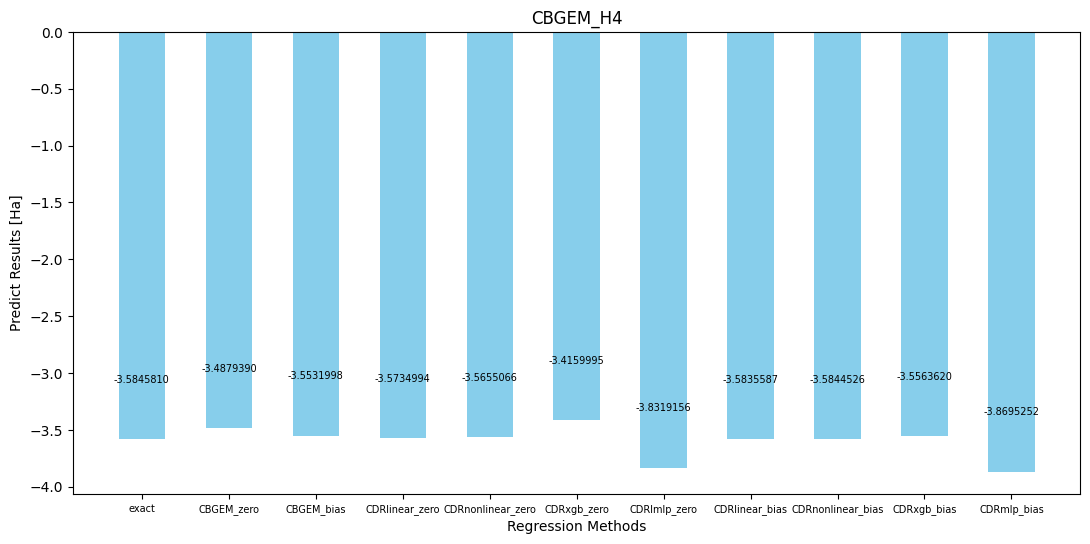

In [ ]:
# 数据
categories = ['exact', 'CBGEM_zero', 'CBGEM_bias', 'CDRlinear_zero', 'CDRnonlinear_zero', 'CDRxgb_zero', 'CDRlmlp_zero', 'CDRlinear_bias', 'CDRnonlinear_bias', 'CDRxgb_bias', 'CDRmlp_bias']
values = [nonclif_ground_state_energy, avg_CGBEM_Zero, avg_CGBEM_Bias, avg_CDRZERO_linear, avg_CDRZERO_nonlinear, avg_CDRZERO_xgb, avg_CDRZERO_mlp, avg_CDRBIASED_linear, avg_CDRBIASED_nonlinear, avg_CDRBIASED_xgb, avg_CDRBIASED_mlp]
plt.figure(figsize=(13, 6))
# 创建 x 的位置，间距更大
x_positions = np.arange(len(categories)) * 1.5  # 原间距扩大到1.5倍
# 设置 x 轴的刻度和标签
plt.xticks(x_positions, categories, fontsize=7)  # 保持标签的字体大小
# 绘制柱状图
plt.bar(x_positions, values, color='skyblue')

# 添加标题和标签
plt.title('CBGEM_H4')
plt.xlabel('Regression Methods')
plt.ylabel('Predict Results [Ha]')


for i, v in enumerate(values):
    plt.text(x_positions[i], v + 0.5, f"{v:.7f}", ha='center', fontsize=7)

# 显示图表
plt.show()